# Customer Churn Prediction & ROI-Backend Retention Playbook

## Project Overview
This notebook implements machine learning models to predict customer churn in the telecom industry.

**Objectives:**
- Analyze customer behavior patterns
- Build predictive models for churn
- Identify key factors driving churn
- Provide actionable retention strategies


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, 
                             classification_report, roc_curve)

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
df = pd.read_csv('Telco-Customer-Churn.csv') 

print(f"Shape: {df.shape}")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

Shape: (7043, 21)
Rows: 7043, Columns: 21


In [3]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
print("="*60)
print("DATASET INFORMATION")
print("="*60)
df.info()

DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043

In [5]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
# Check for missing values
print("Missing Values Count:")
print(df.isnull().sum())


Missing Values Count:
customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


Churn Distribution:
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn Percentage:
Churn
No     73.463013
Yes    26.536987
Name: proportion, dtype: float64


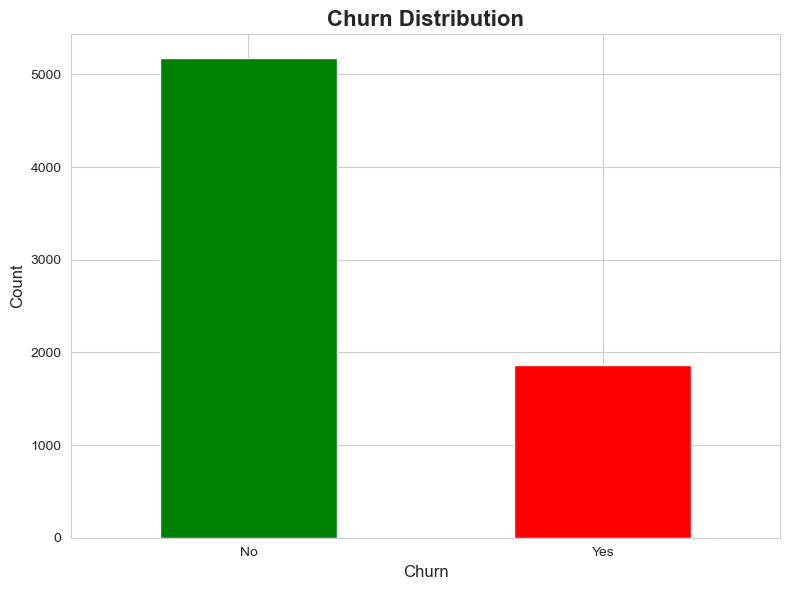

In [7]:
# Analyze churn distribution
print("Churn Distribution:")
print(df['Churn'].value_counts())

print("\n" + "="*50)
churn_percentage = df['Churn'].value_counts(normalize=True) * 100
print("Churn Percentage:")
print(churn_percentage)

# Visualize churn distribution
plt.figure(figsize=(8, 6))
df['Churn'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Churn Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Churn', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [8]:
# Strip spaces and replace empty strings with NaN
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan)

# Check if any NaN appeared (these were the blank spaces)
print("Blank entries found:", df['TotalCharges'].isna().sum())

# Convert safely to float
df['TotalCharges'] = df['TotalCharges'].astype('float64')
df['MonthlyCharges'] = df['MonthlyCharges'].astype('float64')

# Optional: if you want to handle those NaNs (e.g., set them to 0 or median)
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Verify
print(df[['MonthlyCharges', 'TotalCharges']].dtypes)


Blank entries found: 11
MonthlyCharges    float64
TotalCharges      float64
dtype: object


In [9]:
# Fill NaN values in TotalCharges with median
median_total = df['TotalCharges'].median()
df['TotalCharges'] = df['TotalCharges'].fillna(median_total)

# Verify
print(f"Median value used for filling: {median_total}")
print(df[['MonthlyCharges', 'TotalCharges']].dtypes)
print("Remaining NaN after fill:", df['TotalCharges'].isna().sum())

Median value used for filling: 1394.55
MonthlyCharges    float64
TotalCharges      float64
dtype: object
Remaining NaN after fill: 0


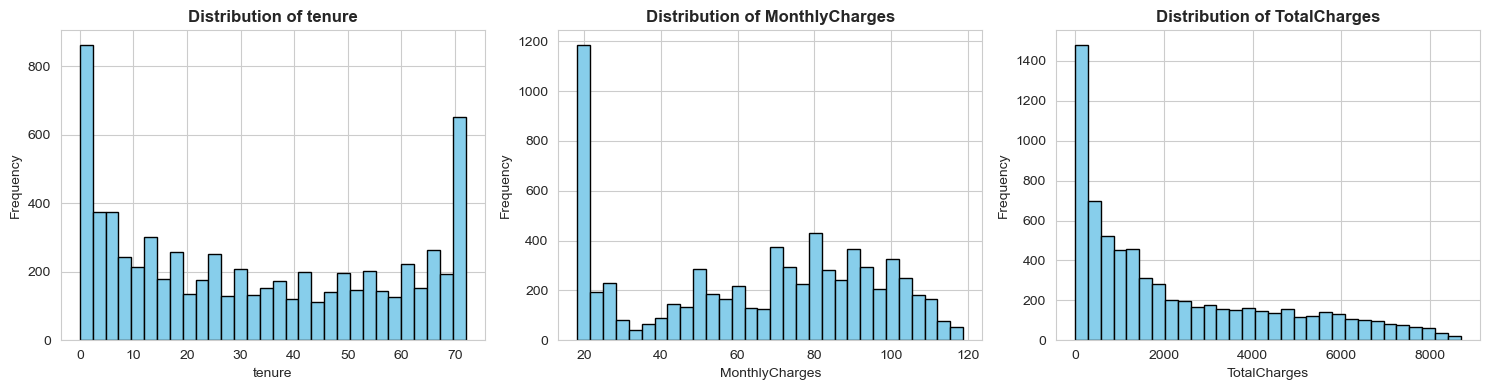

In [10]:
# Analyze numerical features
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
# Visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(df[col], bins=30, color='skyblue', edgecolor='black')
    axes[idx].set_title(f'Distribution of {col}', fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

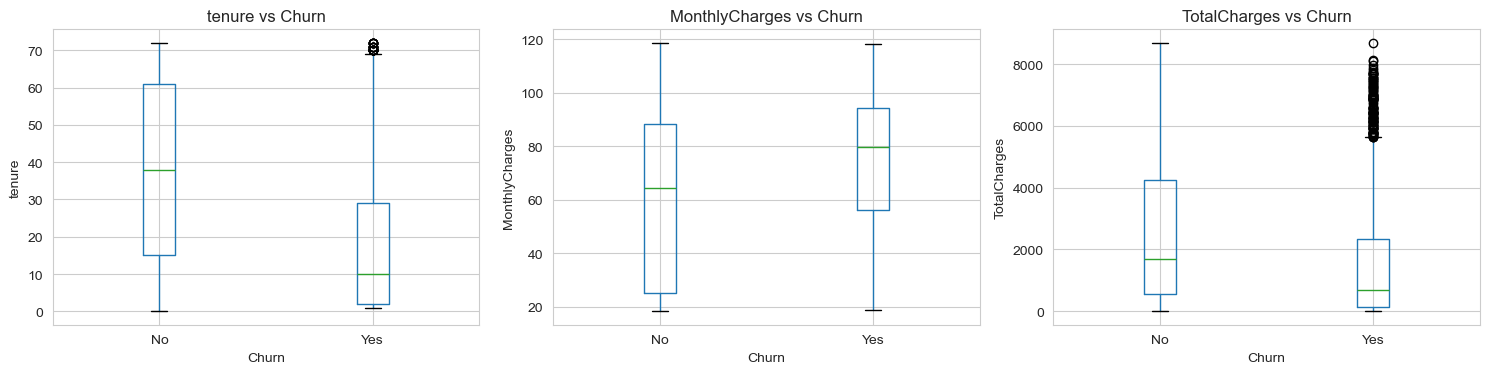

In [11]:
# Analyze numerical features against churn
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, col in enumerate(numerical_cols):
    df.boxplot(column=col, by='Churn', ax=axes[idx])
    axes[idx].set_title(f'{col} vs Churn')
    axes[idx].set_xlabel('Churn')
    axes[idx].set_ylabel(col)

plt.suptitle('')
plt.tight_layout()
plt.show()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [13]:
# List all categorical columns
categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
                    'PhoneService', 'MultipleLines', 'InternetService',
                    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                    'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaperlessBilling', 'PaymentMethod']

# Display unique values for each categorical column
for col in categorical_cols:
    print(f"\n{col} - Unique Values:")
    print(df[col].value_counts())
    print("-" * 40)


gender - Unique Values:
gender
Male      3555
Female    3488
Name: count, dtype: int64
----------------------------------------

SeniorCitizen - Unique Values:
SeniorCitizen
0    5901
1    1142
Name: count, dtype: int64
----------------------------------------

Partner - Unique Values:
Partner
No     3641
Yes    3402
Name: count, dtype: int64
----------------------------------------

Dependents - Unique Values:
Dependents
No     4933
Yes    2110
Name: count, dtype: int64
----------------------------------------

PhoneService - Unique Values:
PhoneService
Yes    6361
No      682
Name: count, dtype: int64
----------------------------------------

MultipleLines - Unique Values:
MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: count, dtype: int64
----------------------------------------

InternetService - Unique Values:
InternetService
Fiber optic    3096
DSL            2421
No             1526
Name: count, dtype: int64
-----------------------

In [14]:
# Calculate churn rate for key categorical features
key_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
                'Contract', 'InternetService', 'PaymentMethod']

for feature in key_features:
    churn_rate = df.groupby(feature)['Churn'].apply(lambda x: (x == 'Yes').sum() / len(x) * 100)
    print(f"\nChurn Rate by {feature}:")
    print(churn_rate.sort_values(ascending=False))
    print("-" * 50)


Churn Rate by gender:
gender
Female    26.920872
Male      26.160338
Name: Churn, dtype: float64
--------------------------------------------------

Churn Rate by SeniorCitizen:
SeniorCitizen
1    41.681261
0    23.606168
Name: Churn, dtype: float64
--------------------------------------------------

Churn Rate by Partner:
Partner
No     32.957979
Yes    19.664903
Name: Churn, dtype: float64
--------------------------------------------------

Churn Rate by Dependents:
Dependents
No     31.279140
Yes    15.450237
Name: Churn, dtype: float64
--------------------------------------------------

Churn Rate by Contract:
Contract
Month-to-month    42.709677
One year          11.269518
Two year           2.831858
Name: Churn, dtype: float64
--------------------------------------------------

Churn Rate by InternetService:
InternetService
Fiber optic    41.892765
DSL            18.959108
No              7.404980
Name: Churn, dtype: float64
--------------------------------------------------

Ch

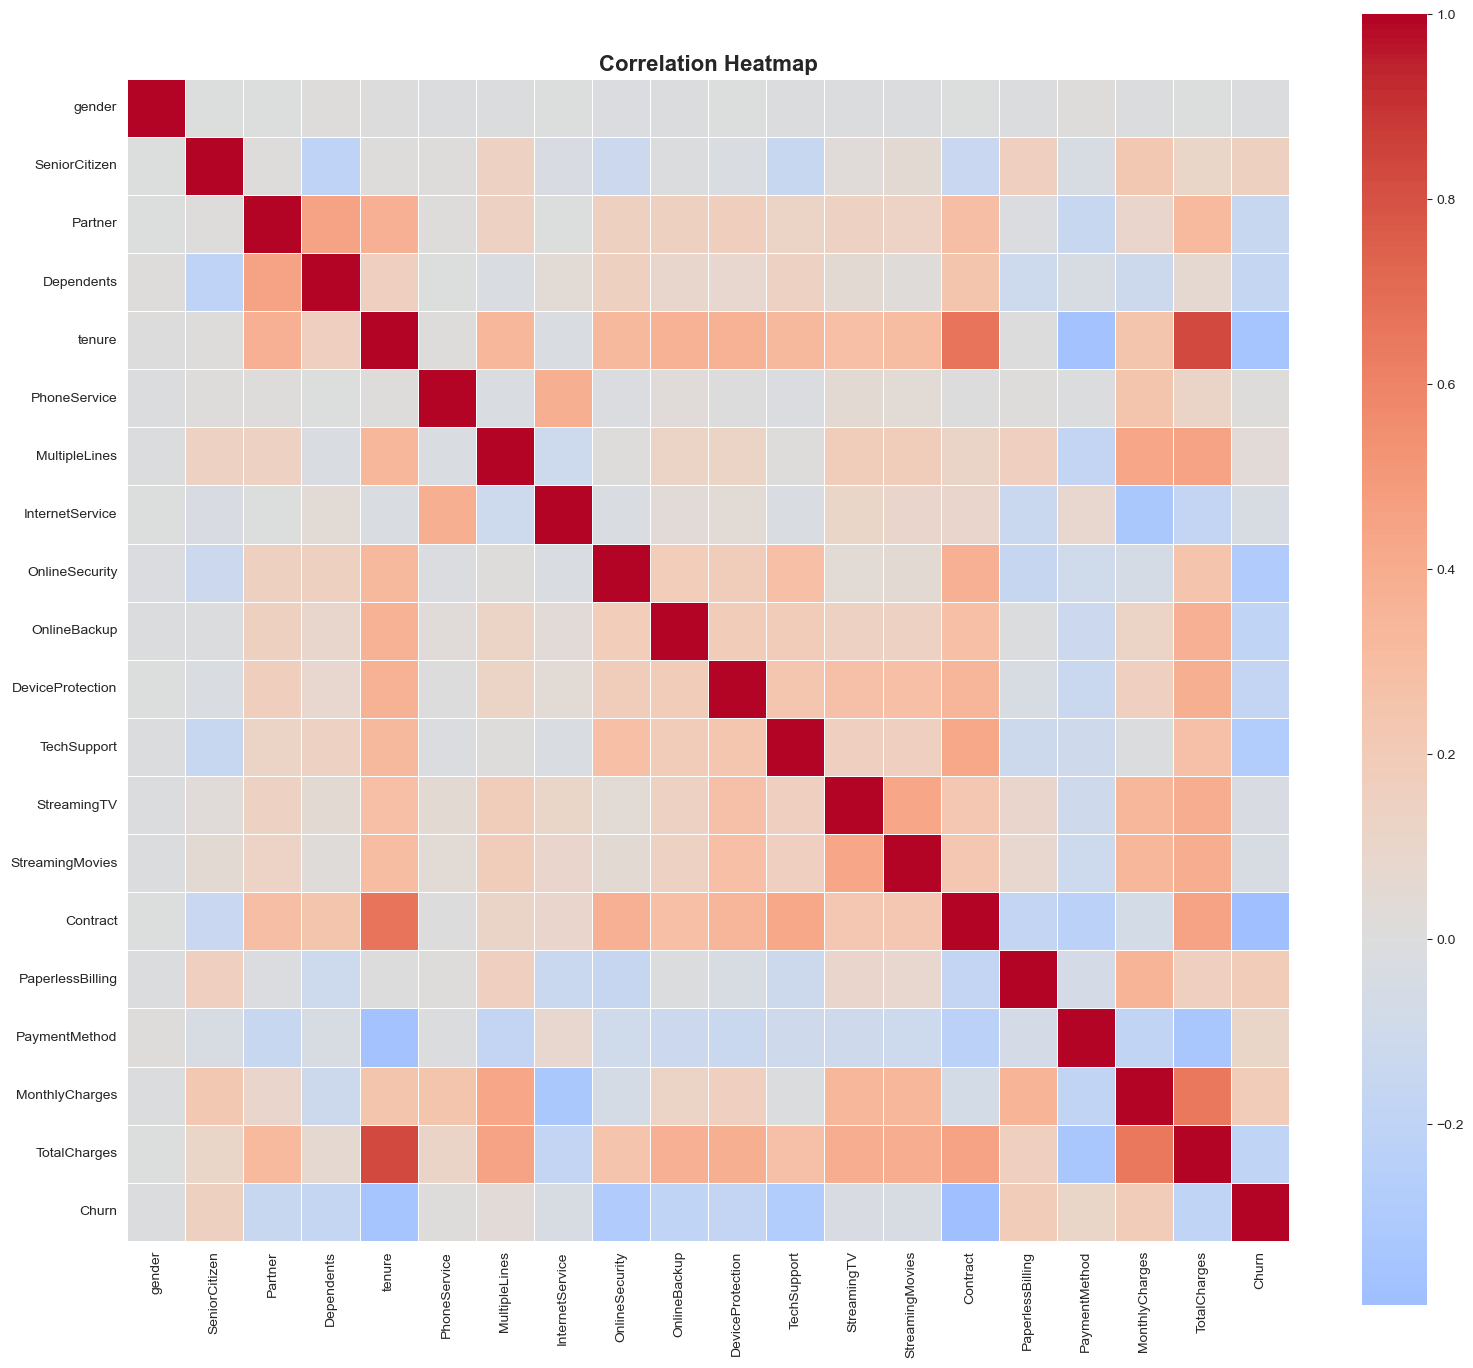


Top Features Correlated with Churn:
Churn               1.000000
MonthlyCharges      0.193356
PaperlessBilling    0.191825
SeniorCitizen       0.150889
PaymentMethod       0.107062
MultipleLines       0.038037
PhoneService        0.011942
gender             -0.008612
StreamingTV        -0.036581
StreamingMovies    -0.038492
Name: Churn, dtype: float64


In [15]:
# Create a copy for encoding
df_encoded = df.copy()

# Encode categorical variables for correlation
label_encoders = {}
for col in df_encoded.select_dtypes(include='object').columns:
    if col != 'customerID':
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col])
        label_encoders[col] = le

# Remove customerID for correlation
df_corr = df_encoded.drop('customerID', axis=1, errors='ignore')

# Calculate correlation matrix
correlation_matrix = df_corr.corr()

# Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Correlation Heatmap', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Show top correlations with Churn
print("\nTop Features Correlated with Churn:")
churn_corr = correlation_matrix['Churn'].sort_values(ascending=False)
print(churn_corr.head(10))

In [16]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes



## Feature Engineering

In [17]:
# Create new features
df['ChargesPerMonth'] = df['TotalCharges'] / (df['tenure'] + 1)
df['TenureGroup'] = pd.cut(df['tenure'], bins=[0, 12, 24, 48, 72], 
                            labels=['0-1 Year', '1-2 Years', '2-4 Years', '4+ Years'])

print("New features created:")
print(df[['tenure', 'TenureGroup', 'ChargesPerMonth']].head(10))

New features created:
   tenure TenureGroup  ChargesPerMonth
0       1    0-1 Year        14.925000
1      34   2-4 Years        53.985714
2       2    0-1 Year        36.050000
3      45   2-4 Years        40.016304
4       2    0-1 Year        50.550000
5       8    0-1 Year        91.166667
6      22   1-2 Years        84.756522
7      10    0-1 Year        27.445455
8      28   2-4 Years       105.036207
9      62    4+ Years        55.364286


In [18]:
from sklearn.preprocessing import LabelEncoder

# List of categorical columns (from your summary)
categorical_cols = [
    'gender', 'SeniorCitizen', 'Partner', 'Dependents',
    'PhoneService', 'MultipleLines', 'InternetService',
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies',
    'Contract', 'PaperlessBilling', 'PaymentMethod'
]

# Initialize the encoder
le = LabelEncoder()

# Apply label encoding to each categorical column
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

print("Label encoding applied successfully to all categorical columns.")
print(df[categorical_cols].head())


Label encoding applied successfully to all categorical columns.
   gender  SeniorCitizen  Partner  Dependents  PhoneService  MultipleLines  \
0       0              0        1           0             0              1   
1       1              0        0           0             1              0   
2       1              0        0           0             1              0   
3       1              0        0           0             0              1   
4       0              0        0           0             1              0   

   InternetService  OnlineSecurity  OnlineBackup  DeviceProtection  \
0                0               0             2                 0   
1                0               2             0                 2   
2                0               2             2                 0   
3                0               2             0                 2   
4                1               0             0                 0   

   TechSupport  StreamingTV  StreamingMovies  

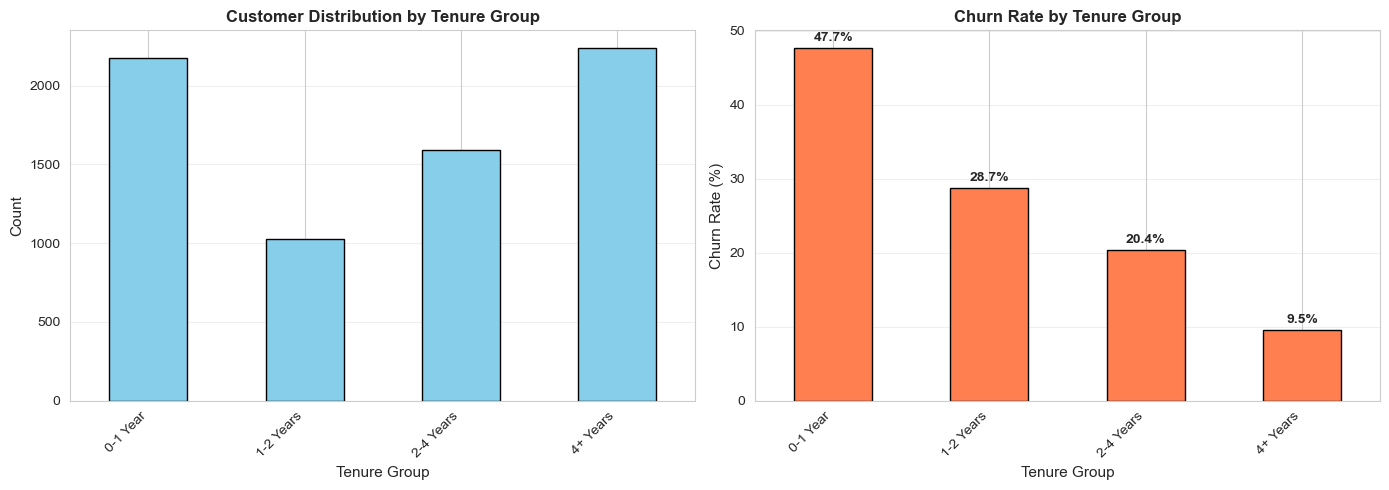

In [19]:
# Visualize tenure groups and churn
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Tenure group distribution
df['TenureGroup'].value_counts().sort_index().plot(kind='bar', ax=axes[0], 
                                                     color='skyblue', edgecolor='black')
axes[0].set_title('Customer Distribution by Tenure Group', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Tenure Group', fontsize=11)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# Compute churn rate by tenure group (exclude missing TenureGroup)
tenure_churn = (
    df.dropna(subset=['TenureGroup'])
      .groupby('TenureGroup')['Churn']
      .apply(lambda x: (x == 'Yes').mean() * 100)
      .sort_index()
)

# If TenureGroup categories are known, ensure consistent order (optional)
ordered_groups = ['0-1 Year', '1-2 Years', '2-4 Years', '4+ Years']
tenure_churn = tenure_churn.reindex([g for g in ordered_groups if g in tenure_churn.index])

# If there is no data to plot, show a message instead of erroring
if tenure_churn.empty:
    axes[1].text(0.5, 0.5, 'No TenureGroup / Churn data available', ha='center', va='center')
    axes[1].set_axis_off()
else:
    # Churn rate by tenure group
    tenure_churn.plot(kind='bar', ax=axes[1], color='coral', edgecolor='black')
    axes[1].set_title('Churn Rate by Tenure Group', fontweight='bold', fontsize=12)
    axes[1].set_xlabel('Tenure Group', fontsize=11)
    axes[1].set_ylabel('Churn Rate (%)', fontsize=11)
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
    axes[1].grid(axis='y', alpha=0.3)

    # Add percentage labels
    for i, v in enumerate(tenure_churn):
        axes[1].text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

In [20]:
print("="*60)
print("PREPARING DATA FOR MACHINE LEARNING")
print("="*60)

df_ml = df.drop(['customerID', 'TenureGroup'], axis=1, errors='ignore')


X = df_ml.drop('Churn', axis=1)
y = df_ml['Churn']

print(f"\n✅ Features shape: {X.shape}")
print(f"✅ Target shape: {y.shape}")

print("\n" + "="*60)
print("TARGET DISTRIBUTION")
print("="*60)
print(y.value_counts())
print(f"\nChurn Rate: {(y == 'Yes').sum() / len(y) * 100:.2f}%")

PREPARING DATA FOR MACHINE LEARNING

✅ Features shape: (7043, 20)
✅ Target shape: (7043,)

TARGET DISTRIBUTION
Churn
No     5174
Yes    1869
Name: count, dtype: int64

Churn Rate: 26.54%


In [21]:
print(y.unique())


['No' 'Yes']


In [22]:
# Now map to 0 and 1
y = y.map({'Yes': 1, 'No': 0})

In [23]:
print(y.unique())


[0 1]


In [24]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("="*60)
print("TRAIN-TEST SPLIT")
print("="*60)
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

print("\n" + "="*60)
print("TRAINING SET TARGET DISTRIBUTION (BEFORE SMOTE-ENN)")
print("="*60)
print(y_train.value_counts())
print(f"Class 0 (No Churn): {(y_train == 0).sum()} ({(y_train == 0).sum() / len(y_train) * 100:.2f}%)")
print(f"Class 1 (Churn): {(y_train == 1).sum()} ({(y_train == 1).sum() / len(y_train) * 100:.2f}%)")

print("\n" + "="*60)
print("TEST SET TARGET DISTRIBUTION")
print("="*60)
print(y_test.value_counts())
print(f"Class 0 (No Churn): {(y_test == 0).sum()} ({(y_test == 0).sum() / len(y_test) * 100:.2f}%)")
print(f"Class 1 (Churn): {(y_test == 1).sum()} ({(y_test == 1).sum() / len(y_test) * 100:.2f}%)")

TRAIN-TEST SPLIT
Training set size: (5634, 20)
Test set size: (1409, 20)

TRAINING SET TARGET DISTRIBUTION (BEFORE SMOTE-ENN)
Churn
0    4139
1    1495
Name: count, dtype: int64
Class 0 (No Churn): 4139 (73.46%)
Class 1 (Churn): 1495 (26.54%)

TEST SET TARGET DISTRIBUTION
Churn
0    1035
1     374
Name: count, dtype: int64
Class 0 (No Churn): 1035 (73.46%)
Class 1 (Churn): 374 (26.54%)


In [25]:
print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)
print("\nTraining set target distribution:")
print(y_train.value_counts())
print("\nTest set target distribution:")
print(y_test.value_counts())

Training set size: (5634, 20)
Test set size: (1409, 20)

Training set target distribution:
Churn
0    4139
1    1495
Name: count, dtype: int64

Test set target distribution:
Churn
0    1035
1     374
Name: count, dtype: int64


## Feature Scaling

In [26]:
# Feature Scaling
print("="*60)
print("FEATURE SCALING")
print("="*60)

scaler = StandardScaler()

# Fit on training data and transform both train and test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✅ Feature scaling completed!")
print(f"\nScaled training data shape: {X_train_scaled.shape}")
print(f"Scaled test data shape: {X_test_scaled.shape}")
print("\nFirst few rows of scaled data:")
print(X_train_scaled.head())

FEATURE SCALING
✅ Feature scaling completed!

Scaled training data shape: (5634, 20)
Scaled test data shape: (1409, 20)

First few rows of scaled data:
        gender  SeniorCitizen   Partner  Dependents    tenure  PhoneService  \
3738  0.994336      -0.441773 -0.969234   -0.651557  0.102371     -3.013090   
3151  0.994336      -0.441773  1.031742    1.534786 -0.711743      0.331885   
4860  0.994336      -0.441773  1.031742    1.534786 -0.793155     -3.013090   
3867 -1.005696      -0.441773  1.031742   -0.651557 -0.263980      0.331885   
3810  0.994336      -0.441773  1.031742    1.534786 -1.281624      0.331885   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
3738       0.055253        -1.183116       -0.919558     -1.040535   
3151      -0.999989         0.174179        1.403666     -1.040535   
4860       0.055253        -1.183116        1.403666      1.227308   
3867      -0.999989        -1.183116       -0.919558      1.227308   
3810      -0.999989    

In [27]:
# Import SMOTE-ENN
from imblearn.combine import SMOTEENN
from collections import Counter

print("="*60)
print("IMPORTING SMOTE-ENN")
print("="*60)
print("SMOTE-ENN imported successfully from imbalanced-learn library!")


IMPORTING SMOTE-ENN
SMOTE-ENN imported successfully from imbalanced-learn library!


In [28]:
# Apply SMOTE-ENN
print("="*60)
print("APPLYING SMOTE-ENN")
print("="*60)

# Initialize SMOTE-ENN
smote_enn = SMOTEENN(random_state=42)

# Store original distribution
print("BEFORE SMOTE-ENN:")
print(f"Training samples: {len(X_train_scaled)}")
print(f"Class distribution: {Counter(y_train)}")
print(f"  Class 0 (No Churn): {(y_train == 0).sum()}")
print(f"  Class 1 (Churn): {(y_train == 1).sum()}")
print(f"Imbalance ratio: {(y_train == 0).sum() / (y_train == 1).sum():.2f}:1")

# Apply SMOTE-ENN to training data only
X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train_scaled, y_train)

print("\n" + "="*60)
print("AFTER SMOTE-ENN:")
print("="*60)
print(f"Training samples: {len(X_train_resampled)}")
print(f"Class distribution: {Counter(y_train_resampled)}")
print(f"  Class 0 (No Churn): {(y_train_resampled == 0).sum()}")
print(f"  Class 1 (Churn): {(y_train_resampled == 1).sum()}")
print(f"Imbalance ratio: {(y_train_resampled == 0).sum() / (y_train_resampled == 1).sum():.2f}:1")

print("\n SMOTE-ENN applied successfully!")
print(f" Samples added: {len(X_train_resampled) - len(X_train_scaled)}")

APPLYING SMOTE-ENN
BEFORE SMOTE-ENN:
Training samples: 5634
Class distribution: Counter({0: 4139, 1: 1495})
  Class 0 (No Churn): 4139
  Class 1 (Churn): 1495
Imbalance ratio: 2.77:1

AFTER SMOTE-ENN:
Training samples: 5038
Class distribution: Counter({1: 2813, 0: 2225})
  Class 0 (No Churn): 2225
  Class 1 (Churn): 2813
Imbalance ratio: 0.79:1

 SMOTE-ENN applied successfully!
 Samples added: -596


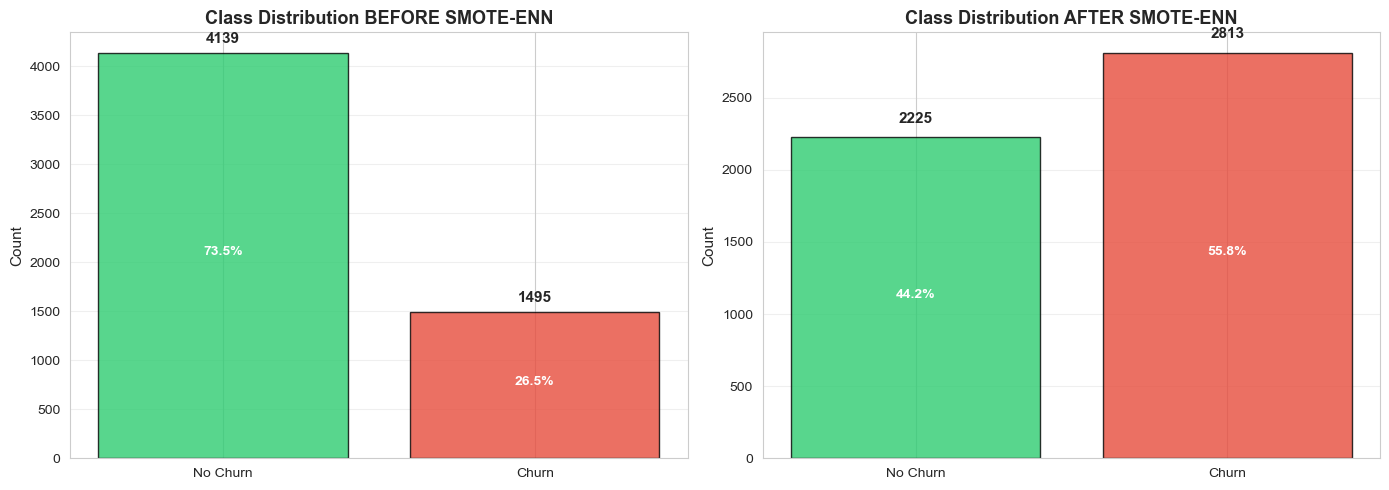

VISUALIZATION COMPLETED


In [29]:
# Visualize class distribution before and after SMOTE-ENN
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before SMOTE-ENN
before_counts = pd.Series(y_train).value_counts().sort_index()
axes[0].bar(['No Churn', 'Churn'], before_counts.values, 
            color=['#2ecc71', '#e74c3c'], edgecolor='black', alpha=0.8)
axes[0].set_title('Class Distribution BEFORE SMOTE-ENN', fontweight='bold', fontsize=13)
axes[0].set_ylabel('Count', fontsize=11)
axes[0].grid(axis='y', alpha=0.3)

# Add count labels
for i, v in enumerate(before_counts.values):
    axes[0].text(i, v + 100, str(v), ha='center', fontweight='bold', fontsize=11)
    axes[0].text(i, v/2, f'{v/len(y_train)*100:.1f}%', ha='center', 
                fontweight='bold', fontsize=10, color='white')

# After SMOTE-ENN
after_counts = pd.Series(y_train_resampled).value_counts().sort_index()
axes[1].bar(['No Churn', 'Churn'], after_counts.values, 
            color=['#2ecc71', '#e74c3c'], edgecolor='black', alpha=0.8)
axes[1].set_title('Class Distribution AFTER SMOTE-ENN', fontweight='bold', fontsize=13)
axes[1].set_ylabel('Count', fontsize=11)
axes[1].grid(axis='y', alpha=0.3)

# Add count labels
for i, v in enumerate(after_counts.values):
    axes[1].text(i, v + 100, str(v), ha='center', fontweight='bold', fontsize=11)
    axes[1].text(i, v/2, f'{v/len(y_train_resampled)*100:.1f}%', ha='center', 
                fontweight='bold', fontsize=10, color='white')

plt.tight_layout()
plt.show()

print("="*60)
print("VISUALIZATION COMPLETED")
print("="*60)

In [30]:
# Summary of SMOTE-ENN impact
print("="*60)
print("SMOTE-ENN IMPACT SUMMARY")
print("="*60)

original_total = len(X_train_scaled)
resampled_total = len(X_train_resampled)
samples_added = resampled_total - original_total

original_minority = (y_train == 1).sum()
resampled_minority = (y_train_resampled == 1).sum()
minority_increase = resampled_minority - original_minority

original_majority = (y_train == 0).sum()
resampled_majority = (y_train_resampled == 0).sum()
majority_decrease = original_majority - resampled_majority

print(f"\n Total Samples:")
print(f"   Before: {original_total}")
print(f"   After:  {resampled_total}")
print(f"   Change: +{samples_added} ({samples_added/original_total*100:.2f}%)")

print(f"\n Minority Class (Churn):")
print(f"   Before: {original_minority}")
print(f"   After:  {resampled_minority}")
print(f"   Change: +{minority_increase} ({minority_increase/original_minority*100:.2f}%)")

print(f"\n Majority Class (No Churn):")
print(f"   Before: {original_majority}")
print(f"   After:  {resampled_majority}")
print(f"   Change: -{majority_decrease} ({-majority_decrease/original_majority*100:.2f}%)")

print(f"\n Class Balance:")
print(f"   Before: {original_majority/original_minority:.2f}:1")
print(f"   After:  {resampled_majority/resampled_minority:.2f}:1")

print("\n Dataset is now balanced and ready for model training!")

SMOTE-ENN IMPACT SUMMARY

 Total Samples:
   Before: 5634
   After:  5038
   Change: +-596 (-10.58%)

 Minority Class (Churn):
   Before: 1495
   After:  2813
   Change: +1318 (88.16%)

 Majority Class (No Churn):
   Before: 4139
   After:  2225
   Change: -1914 (-46.24%)

 Class Balance:
   Before: 2.77:1
   After:  0.79:1

 Dataset is now balanced and ready for model training!


In [31]:
from xgboost import XGBClassifier

# Define all models
print("="*60)
print("DEFINING MACHINE LEARNING MODELS")
print("="*60)

models = {
    "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=10),
    "Random Forest": RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42, n_estimators=100, max_depth=5),
    "XGBoost": XGBClassifier(random_state=42, n_estimators=100, max_depth=5, eval_metric='logloss')
}

print(f"Total models to train: {len(models)}")
for idx, model_name in enumerate(models.keys(), 1):
    print(f"{idx}. {model_name}")
    
print("\n All models defined successfully!")

DEFINING MACHINE LEARNING MODELS
Total models to train: 5
1. Logistic Regression
2. Decision Tree
3. Random Forest
4. Gradient Boosting
5. XGBoost

 All models defined successfully!


In [32]:
# Train and evaluate all models
print("="*80)
print("TRAINING AND EVALUATING ALL MODELS")
print("="*80)

# Store results for comparison
results = []

for i in range(len(list(models))):
    model_name = list(models.keys())[i]
    model = list(models.values())[i]
    
    print("\n" + "="*80)
    print(f"MODEL {i+1}: {model_name}")
    print("="*80)
    
    # Train model on resampled training data
    print("Training model...")
    model.fit(X_train_resampled, y_train_resampled)
    
    # Make predictions
    y_train_pred = model.predict(X_train_resampled)
    y_test_pred = model.predict(X_test_scaled)
    
    # Get prediction probabilities for ROC-AUC
    if hasattr(model, "predict_proba"):
        y_train_pred_proba = model.predict_proba(X_train_resampled)[:, 1]
        y_test_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_train_pred_proba = y_train_pred
        y_test_pred_proba = y_test_pred
    
    # Training set performance
    model_train_accuracy = accuracy_score(y_train_resampled, y_train_pred)
    model_train_f1 = f1_score(y_train_resampled, y_train_pred, average='weighted')
    model_train_precision = precision_score(y_train_resampled, y_train_pred)
    model_train_recall = recall_score(y_train_resampled, y_train_pred)
    model_train_rocauc_score = roc_auc_score(y_train_resampled, y_train_pred_proba)
    
    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred)
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    model_test_precision = precision_score(y_test, y_test_pred)
    model_test_recall = recall_score(y_test, y_test_pred)
    model_test_rocauc_score = roc_auc_score(y_test, y_test_pred_proba)
    
    # Print results
    print("\n Model Performance for Training Set")
    print("-" * 40)
    print(f"  - Accuracy:  {model_train_accuracy:.4f}")
    print(f"  - F1 Score:  {model_train_f1:.4f}")
    print(f"  - Precision: {model_train_precision:.4f}")
    print(f"  - Recall:    {model_train_recall:.4f}")
    print(f"  - ROC-AUC:   {model_train_rocauc_score:.4f}")
    
    print("\n Model Performance for Test Set")
    print("-" * 40)
    print(f"  - Accuracy:  {model_test_accuracy:.4f}")
    print(f"  - F1 Score:  {model_test_f1:.4f}")
    print(f"  - Precision: {model_test_precision:.4f}")
    print(f"  - Recall:    {model_test_recall:.4f}")
    print(f"  - ROC-AUC:   {model_test_rocauc_score:.4f}")
    
    # Store results
    results.append({
        'Model': model_name,
        'Train_Accuracy': model_train_accuracy,
        'Train_F1': model_train_f1,
        'Train_Precision': model_train_precision,
        'Train_Recall': model_train_recall,
        'Train_ROC_AUC': model_train_rocauc_score,
        'Test_Accuracy': model_test_accuracy,
        'Test_F1': model_test_f1,
        'Test_Precision': model_test_precision,
        'Test_Recall': model_test_recall,
        'Test_ROC_AUC': model_test_rocauc_score
    })
    
    print("="*80)

print("\n All models trained and evaluated successfully!")

TRAINING AND EVALUATING ALL MODELS

MODEL 1: Logistic Regression
Training model...

 Model Performance for Training Set
----------------------------------------
  - Accuracy:  0.9135
  - F1 Score:  0.9134
  - Precision: 0.9183
  - Recall:    0.9275
  - ROC-AUC:   0.9719

 Model Performance for Test Set
----------------------------------------
  - Accuracy:  0.7005
  - F1 Score:  0.7180
  - Precision: 0.4654
  - Recall:    0.8636
  - ROC-AUC:   0.8388

MODEL 2: Decision Tree
Training model...

 Model Performance for Training Set
----------------------------------------
  - Accuracy:  0.9839
  - F1 Score:  0.9839
  - Precision: 0.9796
  - Recall:    0.9918
  - ROC-AUC:   0.9980

 Model Performance for Test Set
----------------------------------------
  - Accuracy:  0.7119
  - F1 Score:  0.7282
  - Precision: 0.4744
  - Recall:    0.7914
  - ROC-AUC:   0.7323

MODEL 3: Random Forest
Training model...

 Model Performance for Training Set
----------------------------------------
  - Accurac

In [33]:
# Create comparison dataframe
results_df = pd.DataFrame(results)

print("="*80)
print("MODEL COMPARISON SUMMARY - TEST SET PERFORMANCE")
print("="*80)

# Display test set metrics
test_metrics = results_df[['Model', 'Test_Accuracy', 'Test_Precision', 
                            'Test_Recall', 'Test_F1', 'Test_ROC_AUC']]
test_metrics.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']

print(test_metrics.to_string(index=False))

print("\n" + "="*80)
print("BEST MODELS BY METRIC")
print("="*80)

for metric in ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']:
    best_model = test_metrics.loc[test_metrics[metric].idxmax()]
    print(f"\nBest {metric}: {best_model['Model']} ({best_model[metric]:.4f})")

MODEL COMPARISON SUMMARY - TEST SET PERFORMANCE
              Model  Accuracy  Precision   Recall  F1-Score  ROC-AUC
Logistic Regression  0.700497   0.465418 0.863636  0.717983 0.838836
      Decision Tree  0.711852   0.474359 0.791444  0.728153 0.732331
      Random Forest  0.728886   0.493464 0.807487  0.743996 0.831920
  Gradient Boosting  0.722498   0.486043 0.791444  0.737899 0.830525
            XGBoost  0.731725   0.496575 0.775401  0.745984 0.829315

BEST MODELS BY METRIC

Best Accuracy: XGBoost (0.7317)

Best Precision: XGBoost (0.4966)

Best Recall: Logistic Regression (0.8636)

Best F1-Score: XGBoost (0.7460)

Best ROC-AUC: Logistic Regression (0.8388)


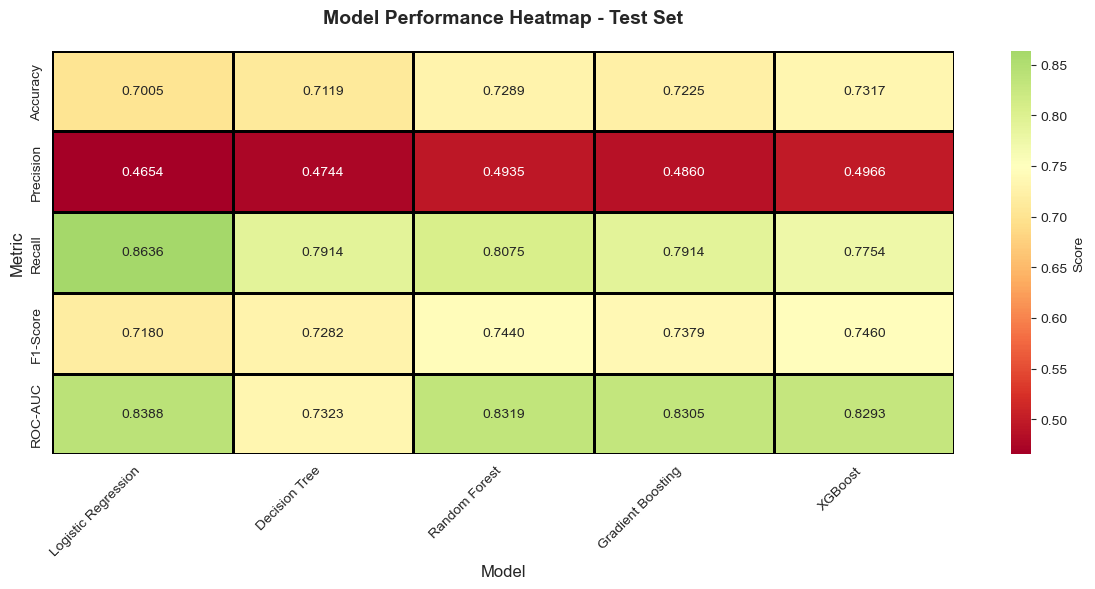

 Performance heatmap created!


In [34]:
# Create heatmap for model comparison
plt.figure(figsize=(12, 6))

heatmap_data = test_metrics.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']]

sns.heatmap(heatmap_data.T, annot=True, fmt='.4f', cmap='RdYlGn', 
            center=0.75, linewidths=1, linecolor='black', 
            cbar_kws={'label': 'Score'})

plt.title('Model Performance Heatmap - Test Set', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Metric', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(" Performance heatmap created!")

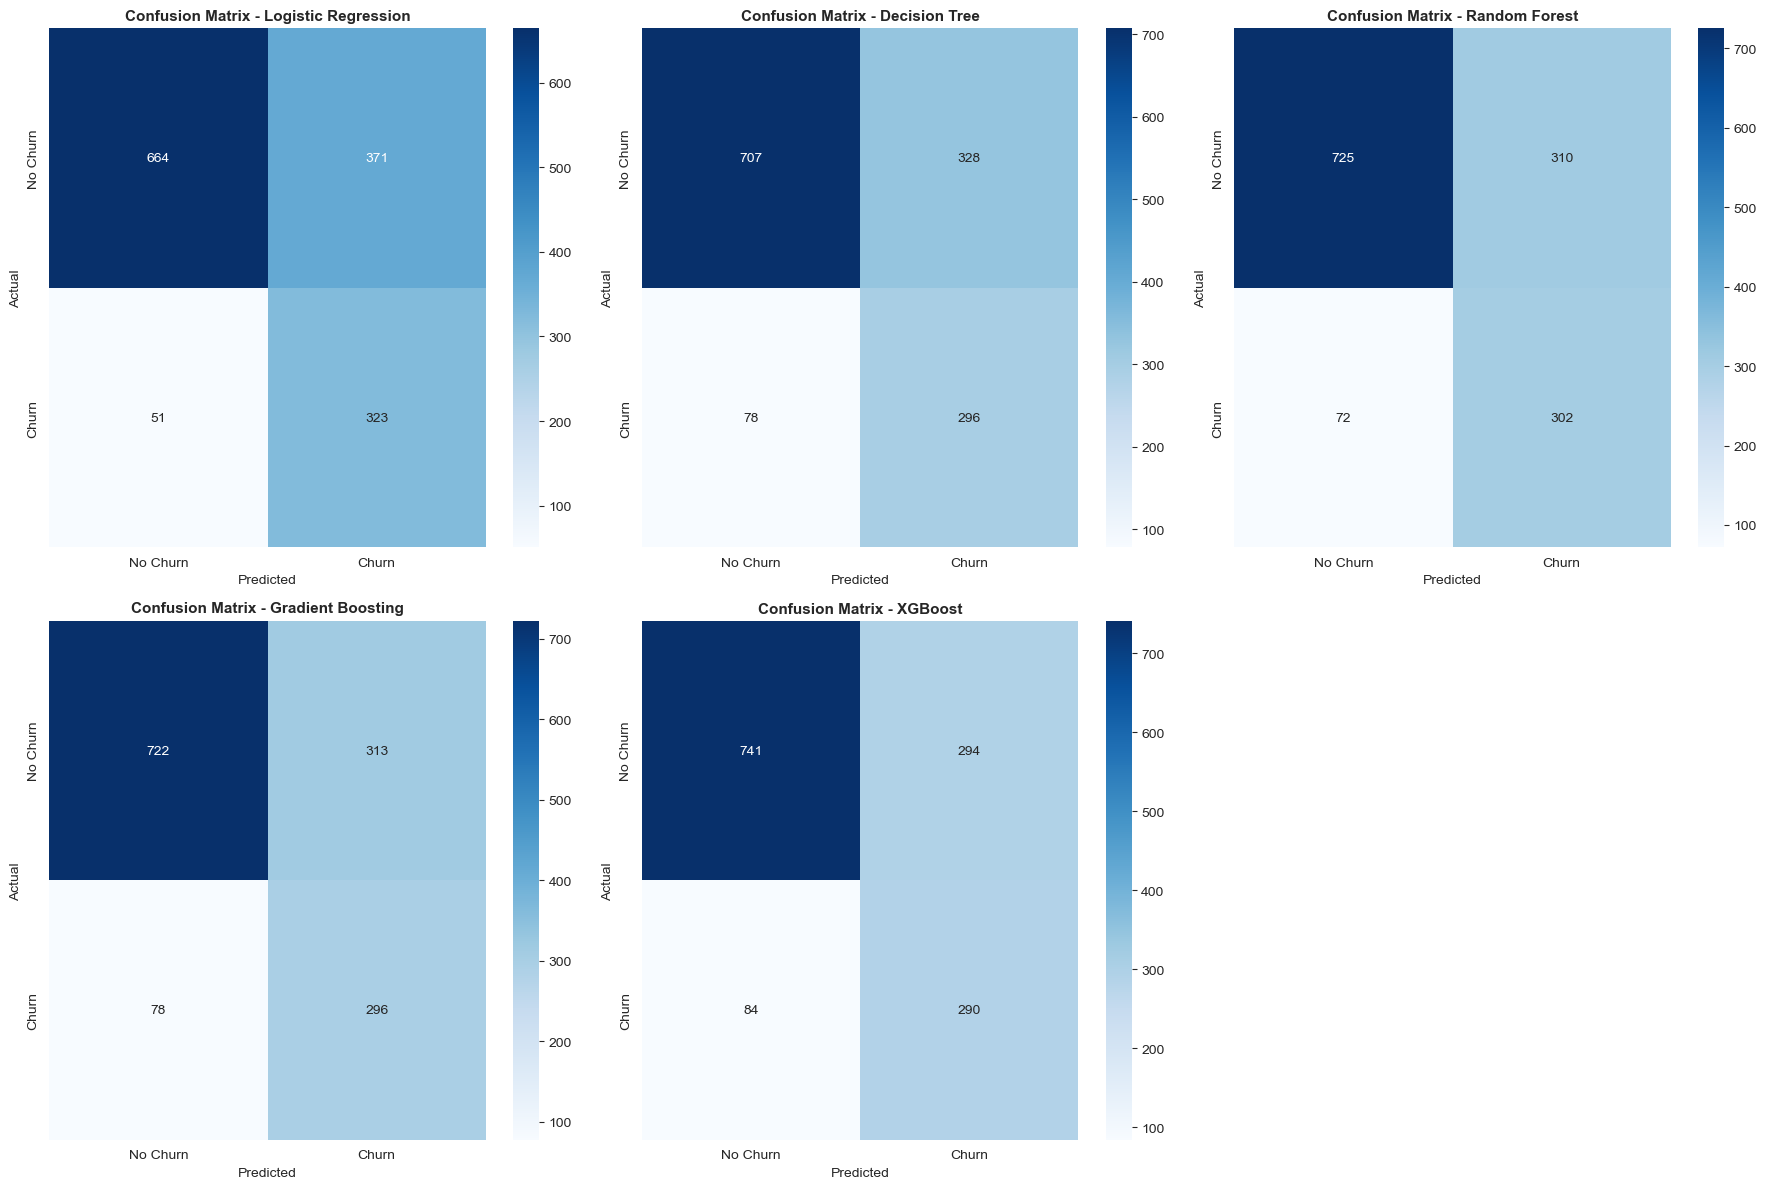

 Confusion matrices for all models displayed!


In [35]:
# Display confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i in range(len(list(models))):
    model_name = list(models.keys())[i]
    model = list(models.values())[i]
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['No Churn', 'Churn'],
                yticklabels=['No Churn', 'Churn'],
                ax=axes[i], cbar=True)
    
    axes[i].set_title(f'Confusion Matrix - {model_name}', fontweight='bold', fontsize=11)
    axes[i].set_xlabel('Predicted', fontsize=10)
    axes[i].set_ylabel('Actual', fontsize=10)

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.show()

print(" Confusion matrices for all models displayed!")

### Hyperparameter Tuning

In [36]:
# Modified hyperparameter grids for better recall
rf_params = {
    'max_depth': [ 10, 15, 20,None],  # Deeper trees to capture patterns
    'n_estimators': [200, 300, 400],  # More trees for stability
    'min_samples_split': [5, 10,15],  # Lower values = more splits = higher recall
    'min_samples_leaf': [4,6,8],  # Lower values = more sensitive
    'max_features': ['sqrt', 'log2'],  # Feature sampling
    'class_weight': ['balanced', {0:1,1:2}]  # Handle imbalance
}

xg_params = {
    'max_depth': [5, 7, 9],
    'n_estimators': [200, 300,400],
    'learning_rate': [0.15, 0.05, 0.1],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'subsample': [0.8, 0.9],
    'scale_pos_weight': [1.5,2,2.5],  # CRITICAL: Bias toward positive class (churners)
    'min_child_weight': [3,5,7],  # Control overfitting
    'gamma': [0, 0.1, 0.2] , # Regularization
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 2]
}


In [37]:
from sklearn.metrics import make_scorer


# Custom scorer that prioritizes recall but considers F1
def custom_churn_scorer(y_true, y_pred):
    rec = recall_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    # Weighted score: 70% recall + 30% F1
    return 0.6 *f1 + 0.4 * rec

churn_scorer = make_scorer(custom_churn_scorer)


In [38]:
from xgboost import XGBClassifier

In [39]:
randomcv_models = [
    ("Random Forest", RandomForestClassifier(random_state=42), rf_params),
    ("XGBoost", XGBClassifier( random_state=42, eval_metric='logloss'), xg_params)
]

In [42]:
from sklearn.model_selection import RandomizedSearchCV
model_param = {}
best_models = {}

for name, model, params in randomcv_models:
    print(f"\n{'='*60}")
    print(f"🔹 Tuning {name}...")
    print(f"{'='*60}\n")
    
    random_cv = RandomizedSearchCV(
        estimator=model,
        param_distributions=params,
        n_iter=75,
        scoring=churn_scorer,
        cv=5,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    
    random_cv.fit(X_train, y_train)
    model_param[name] = random_cv.best_params_
    best_models[name] = random_cv.best_estimator_
    
    print(f"\n✅ Best parameters: {random_cv.best_params_}")
    print(f"📊 Best CV Score: {random_cv.best_score_:.4f}")



🔹 Tuning Random Forest...

Fitting 5 folds for each of 75 candidates, totalling 375 fits

✅ Best parameters: {'n_estimators': 300, 'min_samples_split': 5, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'max_depth': 10, 'class_weight': 'balanced'}
📊 Best CV Score: 0.6868

🔹 Tuning XGBoost...

Fitting 5 folds for each of 75 candidates, totalling 375 fits

✅ Best parameters: {'subsample': 0.9, 'scale_pos_weight': 2.5, 'reg_lambda': 2, 'reg_alpha': 0, 'n_estimators': 200, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 0.7}
📊 Best CV Score: 0.6765


In [43]:
models={
    "Random Forest":RandomForestClassifier(n_estimators=300, min_samples_split=5, max_features='sqrt', max_depth=10,min_samples_leaf=8,class_weight='balanced'),
    "XGBoost":XGBClassifier(colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=200,min_child_weight=7, scale_pos_weight=2.5, subsample=0.9, gamma=0.1),
}

for i in range(len(list(models))):
    model=list(models.values())[i]
    model.fit(X_train,y_train)

    #Make Predictions
    y_train_pred=model.predict(X_train)
    y_test_pred=model.predict(X_test)

    #Training set performance
    model_train_accuracy=accuracy_score(y_train,y_train_pred)
    model_train_f1=f1_score(y_train,y_train_pred)
    model_train_precision=precision_score(y_train,y_train_pred)
    model_train_recall=recall_score(y_train,y_train_pred)
    model_train_roc_auc=roc_auc_score(y_train,y_train_pred)

    #Test set Performance
    model_test_accuracy=accuracy_score(y_test,y_test_pred)
    model_test_f1=f1_score(y_test,y_test_pred)
    model_test_precision=precision_score(y_test,y_test_pred)
    model_test_recall=recall_score(y_test,y_test_pred)
    model_test_roc_auc=roc_auc_score(y_test,y_test_pred)


    print(list(models.keys())[i])
    
    print("Model Performance for Training set")
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print("- F1-Score: {:.4f}".format(model_train_f1))
    print("- Precision: {:.4f}".format(model_train_precision))
    print("- Recall: {:.4f}".format(model_train_recall))
    print("- ROC-AUC Score: {:.4f}".format(model_train_roc_auc))

    print("----------------------------------------------")
    
    print("Model Performance for Test set")
    print("- Accuracy: {:.4f}".format(model_test_accuracy))
    print("- F1-Score: {:.4f}".format(model_test_f1))
    print("- Precision: {:.4f}".format(model_test_precision))
    print("- Recall: {:.4f}".format(model_test_recall))
    print("- ROC-AUC Score: {:.4f}".format(model_test_roc_auc))


    print("-"*35)

Random Forest
Model Performance for Training set
- Accuracy: 0.8241
- F1-Score: 0.7211
- Precision: 0.6224
- Recall: 0.8569
- ROC-AUC Score: 0.8346
----------------------------------------------
Model Performance for Test set
- Accuracy: 0.7729
- F1-Score: 0.6437
- Precision: 0.5515
- Recall: 0.7727
- ROC-AUC Score: 0.7728
-----------------------------------
XGBoost
Model Performance for Training set
- Accuracy: 0.8236
- F1-Score: 0.7231
- Precision: 0.6196
- Recall: 0.8682
- ROC-AUC Score: 0.8378
----------------------------------------------
Model Performance for Test set
- Accuracy: 0.7608
- F1-Score: 0.6260
- Precision: 0.5351
- Recall: 0.7540
- ROC-AUC Score: 0.7586
-----------------------------------


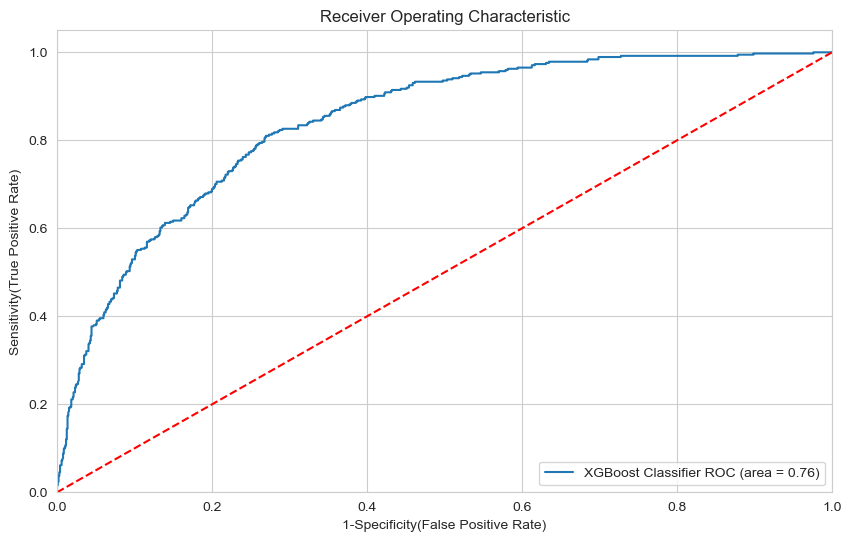

In [44]:
## Plot ROC AUC Curve
from sklearn.metrics import roc_auc_score,roc_curve
plt.figure()

# Add the models to the list that you want to view on the ROC plot
auc_models = [
{
    'label': 'XGBoost Classifier',
    'model':XGBClassifier(colsample_bytree=0.7, learning_rate=0.05, max_depth=5, n_estimators=200,min_child_weight=7, scale_pos_weight=2.5, subsample=0.9, gamma=0.1),
    'auc':  0.7586
},
    
]
# create loop through all model
for algo in auc_models:
    model = algo['model'] # select the model
    model.fit(X_train, y_train) # train the model
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (algo['label'], algo['auc']))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show() 

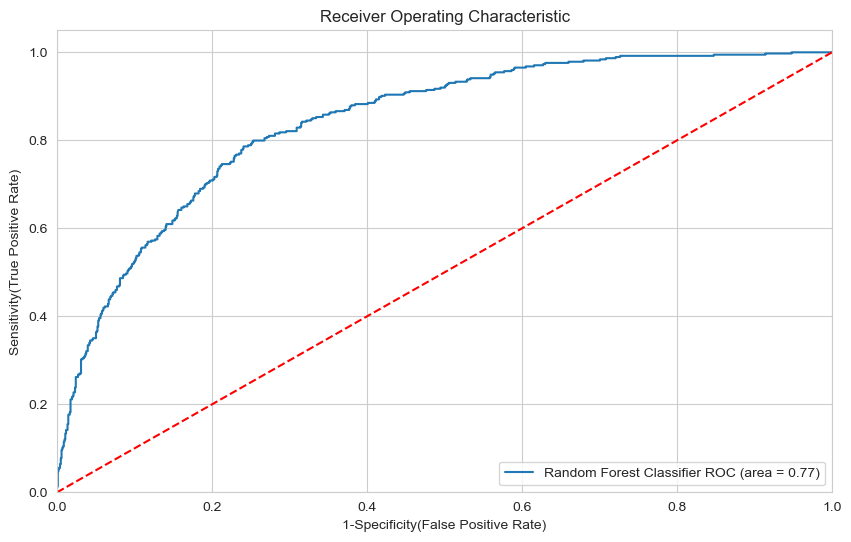

In [45]:
## Plot ROC AUC Curve
from sklearn.metrics import roc_auc_score,roc_curve
plt.figure()

# Add the models to the list that you want to view on the ROC plot
auc_models = [
{
    'label': 'Random Forest Classifier',
    'model':RandomForestClassifier(n_estimators=300, min_samples_split=5, max_features='sqrt', max_depth=10,min_samples_leaf=8,class_weight='balanced'),
    'auc':  0.7728
},
    
]
# create loop through all model
for algo in auc_models:
    model = algo['model'] # select the model
    model.fit(X_train, y_train) # train the model
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (algo['label'], algo['auc']))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show() 